# Investigate VTM Variability, Subtract from Dataset, Measure Performance and Feature Importance after Subtraction 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
sys.path.append('../src')

In [3]:
import models
from models import LinearModel
from models import LGBM
import utils
import plotting
import delong
from sklearn.preprocessing import StandardScaler

# Load and Process VTM

In [4]:
# load VTM data
vtm_path = '../data/VTM_data/VTM_only.csv'
vtm_df = pd.read_csv(vtm_path, skiprows=1, index_col=0).transpose()

In [5]:
var = vtm_df.var()

In [6]:
std = vtm_df.std()
mean = vtm_df.mean()

In [7]:
cv = std / mean

In [8]:
pd.set_option('display.max_colwidth', -1)

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [9]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    top_cv = cv.fillna(0).sort_values()[-25:]
    print(top_cv)

Compound
2.73_161.0241m/z     0.032646
1.88_115.0367m/z     0.032722
6.43_238.1417n       0.033603
7.42_282.1689n       0.034207
10.18_308.2202n      0.037486
10.03_765.7963n      0.041713
11.72_613.2820m/z    0.042008
17.39_604.7907m/z    0.042172
6.00_1041.1873m/z    0.042818
10.09_845.1854n      0.043382
10.03_753.7716n      0.043630
10.18_767.1715n      0.044975
10.04_746.1170n      0.046447
10.11_934.5516m/z    0.049829
8.70_370.3182n       0.051047
11.75_235.1846m/z    0.052493
10.02_250.1782n      0.054386
10.10_895.5277m/z    0.060034
16.09_175.1450m/z    0.066019
5.29_226.1689n       0.139785
9.29_521.2862m/z     0.142693
9.60_352.1139n       0.143077
10.39_204.1234m/z    0.155131
10.96_118.1230m/z    0.321619
7.90_106.0866m/z     0.355703
dtype: float64


In [10]:
vtm_df.loc[:, list(top_cv.keys())]

Compound,2.73_161.0241m/z,1.88_115.0367m/z,6.43_238.1417n,7.42_282.1689n,10.18_308.2202n,10.03_765.7963n,11.72_613.2820m/z,17.39_604.7907m/z,6.00_1041.1873m/z,10.09_845.1854n,...,11.75_235.1846m/z,10.02_250.1782n,10.10_895.5277m/z,16.09_175.1450m/z,5.29_226.1689n,9.29_521.2862m/z,9.60_352.1139n,10.39_204.1234m/z,10.96_118.1230m/z,7.90_106.0866m/z
20191022 126 VTM BLANK-r001,8810.582998,20403.60211,2203.802048,53848.23426,10721.22389,20146.95428,4188.663480,9881.070737,4597.802489,12358.00240,...,3416.937060,2577.515238,24846.50723,1907.501534,701.273096,50663.48493,86.415431,452.025535,53.187355,147.028318
20191022 126 VTM BLANK-r002,8926.883770,19665.67350,2314.547498,51413.82799,10893.38419,18534.22814,4548.337283,10606.253730,5005.996695,12609.77659,...,3556.191480,2341.162000,25372.94891,2127.832302,678.842151,49160.52053,75.909857,505.862946,98.643124,148.893151
20191022 126 VTM BLANK-r003,9369.622810,19117.09000,2351.727333,50393.81181,10136.50337,19429.00653,4439.982113,9854.600371,4854.727306,13420.33714,...,3202.720906,2357.818019,22626.33975,2156.563069,870.664761,38583.98732,64.758356,369.573708,66.345509,72.348220


# Subtract Mean VTM from the Dataset

In [11]:
# read data
all_data = utils.load_unformatted_data('../data/retrospective_influenza_dataset/20191105 resp data no filter revised 1 2020.csv', '../data/retrospective_influenza_dataset/Sample_key_csv revised 1 2020.csv')
all_data = utils.map_label_column(all_data)
all_data, flu_mapping, subtype_mapping = utils.encode_labels(all_data)

# drop zero cols
all_data = all_data.loc[:, all_data.any()]
col_names = all_data.columns[:-2]

In [13]:
def get_vtm_subtraction(data_df, vtm_df):
    """ Iterate over columns in the data_df.
    If the column m/z value is found in the vtm_df, 
    add that value to the vtm_subtraction array. 
    Else, append 0.
    Track the vtm_df columns that are found in the data_df.
    """
    vtm_cols = set(vtm_df.columns)
    match = set()
    vtm_subtraction = []
    
    for col in data_df.columns:
        if col in vtm_cols:
            vtm_subtraction.append(vtm_df[col].mean())
            match.add(col)
        else:
            vtm_subtraction.append(0)
            
    return vtm_subtraction, match            

In [14]:
vtm_subtraction, match = get_vtm_subtraction(all_data, vtm_df)

# Train and Evaluate model using VTM Subtracted Data

In [15]:
# train test split
train, test = utils.train_test_split(all_data, test_size=50)

# subtract VTM from the test data
test = test - vtm_subtraction

In [17]:
test.flu.value_counts()

0.0    26
1.0    24
Name: flu, dtype: int64

In [18]:
# split into data
X_train, y_train = utils.df_to_array(train)
X_test, y_test = utils.df_to_array(test)

In [19]:
#processor = utils.CustomPreprocessor(transforms = ['clip', 'noise', 'power'])
#processor = utils.CustomPreprocessor(transforms = ['standard'])
processor = utils.CustomPreprocessor(transforms = ['quantile'])
processor.fit(X_train)
norm_X_train = processor.transform(X_train)
norm_X_test = processor.transform(X_test)

n_quantiles (1000) is greater than the total number of samples (186). n_quantiles is set to n_samples.


# Random Forest Hyperparameter Optimization

In [20]:
from models import RandomForest
rf_model = RandomForest('RF', {})
best_params = rf_model.random_search(4, X_train, y_train)
rf_model = RandomForest('RF', best_params)

Fitting 4 folds for each of 100 candidates, totalling 400 fits
[CV] max_depth=2, min_samples_split=2, n_estimators=4 ................
[CV]  max_depth=2, min_samples_split=2, n_estimators=4, score=0.766, total=   0.0s
[CV] max_depth=2, min_samples_split=2, n_estimators=4 ................
[CV]  max_depth=2, min_samples_split=2, n_estimators=4, score=0.723, total=   0.0s
[CV] max_depth=2, min_samples_split=2, n_estimators=4 ................
[CV]  max_depth=2, min_samples_split=2, n_estimators=4, score=0.913, total=   0.0s
[CV] max_depth=2, min_samples_split=2, n_estimators=4 ................
[CV]  max_depth=2, min_samples_split=2, n_estimators=4, score=0.804, total=   0.0s
[CV] max_depth=2, min_samples_split=2, n_estimators=16 ...............
[CV]  max_depth=2, min_samples_split=2, n_estimators=16, score=0.766, total=   0.0s
[CV] max_depth=2, min_samples_split=2, n_estimators=16 ...............
[CV]  max_depth=2, min_samples_split=2, n_estimators=16, score=0.787, total=   0.0s
[CV] max_de

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.2s remaining:    0.0s


[CV]  max_depth=2, min_samples_split=2, n_estimators=64, score=0.766, total=   0.1s
[CV] max_depth=2, min_samples_split=2, n_estimators=64 ...............
[CV]  max_depth=2, min_samples_split=2, n_estimators=64, score=0.830, total=   0.1s
[CV] max_depth=2, min_samples_split=2, n_estimators=64 ...............


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s remaining:    0.0s


[CV]  max_depth=2, min_samples_split=2, n_estimators=64, score=0.913, total=   0.1s
[CV] max_depth=2, min_samples_split=2, n_estimators=64 ...............
[CV]  max_depth=2, min_samples_split=2, n_estimators=64, score=0.891, total=   0.1s
[CV] max_depth=2, min_samples_split=2, n_estimators=256 ..............


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.7s remaining:    0.0s


[CV]  max_depth=2, min_samples_split=2, n_estimators=256, score=0.745, total=   0.5s
[CV] max_depth=2, min_samples_split=2, n_estimators=256 ..............


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    1.2s remaining:    0.0s


[CV]  max_depth=2, min_samples_split=2, n_estimators=256, score=0.851, total=   0.5s
[CV] max_depth=2, min_samples_split=2, n_estimators=256 ..............


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    1.7s remaining:    0.0s


[CV]  max_depth=2, min_samples_split=2, n_estimators=256, score=0.913, total=   0.5s
[CV] max_depth=2, min_samples_split=2, n_estimators=256 ..............


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    2.2s remaining:    0.0s


[CV]  max_depth=2, min_samples_split=2, n_estimators=256, score=0.891, total=   0.5s
[CV] max_depth=2, min_samples_split=4, n_estimators=4 ................
[CV]  max_depth=2, min_samples_split=4, n_estimators=4, score=0.702, total=   0.0s
[CV] max_depth=2, min_samples_split=4, n_estimators=4 ................
[CV]  max_depth=2, min_samples_split=4, n_estimators=4, score=0.787, total=   0.0s
[CV] max_depth=2, min_samples_split=4, n_estimators=4 ................
[CV]  max_depth=2, min_samples_split=4, n_estimators=4, score=0.870, total=   0.0s
[CV] max_depth=2, min_samples_split=4, n_estimators=4 ................
[CV]  max_depth=2, min_samples_split=4, n_estimators=4, score=0.761, total=   0.0s
[CV] max_depth=2, min_samples_split=4, n_estimators=16 ...............
[CV]  max_depth=2, min_samples_split=4, n_estimators=16, score=0.681, total=   0.0s
[CV] max_depth=2, min_samples_split=4, n_estimators=16 ...............
[CV]  max_depth=2, min_samples_split=4, n_estimators=16, score=0.851, tot

[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    2.9s remaining:    0.0s


[CV]  max_depth=2, min_samples_split=4, n_estimators=64, score=0.723, total=   0.1s
[CV] max_depth=2, min_samples_split=4, n_estimators=64 ...............
[CV]  max_depth=2, min_samples_split=4, n_estimators=64, score=0.851, total=   0.1s
[CV] max_depth=2, min_samples_split=4, n_estimators=64 ...............


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:    3.1s remaining:    0.0s


[CV]  max_depth=2, min_samples_split=4, n_estimators=64, score=0.870, total=   0.1s
[CV] max_depth=2, min_samples_split=4, n_estimators=64 ...............
[CV]  max_depth=2, min_samples_split=4, n_estimators=64, score=0.891, total=   0.1s
[CV] max_depth=2, min_samples_split=4, n_estimators=256 ..............


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    3.4s remaining:    0.0s


[CV]  max_depth=2, min_samples_split=4, n_estimators=256, score=0.723, total=   0.5s
[CV] max_depth=2, min_samples_split=4, n_estimators=256 ..............


[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:    3.9s remaining:    0.0s


[CV]  max_depth=2, min_samples_split=4, n_estimators=256, score=0.851, total=   0.5s
[CV] max_depth=2, min_samples_split=4, n_estimators=256 ..............


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    4.3s remaining:    0.0s


[CV]  max_depth=2, min_samples_split=4, n_estimators=256, score=0.913, total=   0.5s
[CV] max_depth=2, min_samples_split=4, n_estimators=256 ..............


[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed:    4.8s remaining:    0.0s


[CV]  max_depth=2, min_samples_split=4, n_estimators=256, score=0.891, total=   0.5s
[CV] max_depth=2, min_samples_split=8, n_estimators=4 ................
[CV]  max_depth=2, min_samples_split=8, n_estimators=4, score=0.638, total=   0.0s
[CV] max_depth=2, min_samples_split=8, n_estimators=4 ................
[CV]  max_depth=2, min_samples_split=8, n_estimators=4, score=0.766, total=   0.0s
[CV] max_depth=2, min_samples_split=8, n_estimators=4 ................
[CV]  max_depth=2, min_samples_split=8, n_estimators=4, score=0.783, total=   0.0s
[CV] max_depth=2, min_samples_split=8, n_estimators=4 ................
[CV]  max_depth=2, min_samples_split=8, n_estimators=4, score=0.717, total=   0.0s
[CV] max_depth=2, min_samples_split=8, n_estimators=16 ...............
[CV]  max_depth=2, min_samples_split=8, n_estimators=16, score=0.660, total=   0.0s
[CV] max_depth=2, min_samples_split=8, n_estimators=16 ...............
[CV]  max_depth=2, min_samples_split=8, n_estimators=16, score=0.809, tot

[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    5.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:    5.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:    5.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    5.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    5.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:    5.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:    5.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:    5.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    5.5s remaining:    0.0s


[CV]  max_depth=2, min_samples_split=8, n_estimators=64, score=0.723, total=   0.1s
[CV] max_depth=2, min_samples_split=8, n_estimators=64 ...............
[CV]  max_depth=2, min_samples_split=8, n_estimators=64, score=0.872, total=   0.1s
[CV] max_depth=2, min_samples_split=8, n_estimators=64 ...............


[Parallel(n_jobs=1)]: Done  41 out of  41 | elapsed:    5.6s remaining:    0.0s


[CV]  max_depth=2, min_samples_split=8, n_estimators=64, score=0.913, total=   0.1s
[CV] max_depth=2, min_samples_split=8, n_estimators=64 ...............
[CV]  max_depth=2, min_samples_split=8, n_estimators=64, score=0.913, total=   0.1s
[CV] max_depth=2, min_samples_split=8, n_estimators=256 ..............
[CV]  max_depth=2, min_samples_split=8, n_estimators=256, score=0.745, total=   0.5s
[CV] max_depth=2, min_samples_split=8, n_estimators=256 ..............
[CV]  max_depth=2, min_samples_split=8, n_estimators=256, score=0.851, total=   0.5s
[CV] max_depth=2, min_samples_split=8, n_estimators=256 ..............
[CV]  max_depth=2, min_samples_split=8, n_estimators=256, score=0.913, total=   0.5s
[CV] max_depth=2, min_samples_split=8, n_estimators=256 ..............
[CV]  max_depth=2, min_samples_split=8, n_estimators=256, score=0.891, total=   0.5s
[CV] max_depth=2, min_samples_split=16, n_estimators=4 ...............
[CV]  max_depth=2, min_samples_split=16, n_estimators=4, score=0.5

[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  1.3min finished
The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.


In [21]:
rf_model.run_cv(X_train, y_train, 4)

# LGBM Hyperparameter Optimization

In [22]:
from models import LGBM
lgbm_model = LGBM('LGBM', {})
best_params = lgbm_model.random_search(4, X_train, y_train)
lgbm_model = LGBM('LGBM', best_params)

Fitting 4 folds for each of 90 candidates, totalling 360 fits
[CV] max_depth=2, min_data_in_leaf=2, num_leaves=4 ...................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=2, min_data_in_leaf=2, num_leaves=4, score=0.787, total=   0.3s
[CV] max_depth=2, min_data_in_leaf=2, num_leaves=4 ...................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  max_depth=2, min_data_in_leaf=2, num_leaves=4, score=0.894, total=   0.3s
[CV] max_depth=2, min_data_in_leaf=2, num_leaves=4 ...................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV]  max_depth=2, min_data_in_leaf=2, num_leaves=4, score=0.935, total=   0.3s
[CV] max_depth=2, min_data_in_leaf=2, num_leaves=4 ...................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s


[CV]  max_depth=2, min_data_in_leaf=2, num_leaves=4, score=0.826, total=   0.3s
[CV] max_depth=2, min_data_in_leaf=2, num_leaves=8 ...................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.2s remaining:    0.0s


[CV]  max_depth=2, min_data_in_leaf=2, num_leaves=8, score=0.787, total=   0.3s
[CV] max_depth=2, min_data_in_leaf=2, num_leaves=8 ...................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.4s remaining:    0.0s


[CV]  max_depth=2, min_data_in_leaf=2, num_leaves=8, score=0.894, total=   0.3s
[CV] max_depth=2, min_data_in_leaf=2, num_leaves=8 ...................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.7s remaining:    0.0s


[CV]  max_depth=2, min_data_in_leaf=2, num_leaves=8, score=0.935, total=   0.3s
[CV] max_depth=2, min_data_in_leaf=2, num_leaves=8 ...................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.0s remaining:    0.0s


[CV]  max_depth=2, min_data_in_leaf=2, num_leaves=8, score=0.826, total=   0.3s
[CV] max_depth=2, min_data_in_leaf=2, num_leaves=16 ..................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.3s remaining:    0.0s


[CV]  max_depth=2, min_data_in_leaf=2, num_leaves=16, score=0.787, total=   0.3s
[CV] max_depth=2, min_data_in_leaf=2, num_leaves=16 ..................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.5s remaining:    0.0s


[CV]  max_depth=2, min_data_in_leaf=2, num_leaves=16, score=0.894, total=   0.3s
[CV] max_depth=2, min_data_in_leaf=2, num_leaves=16 ..................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s remaining:    0.0s


[CV]  max_depth=2, min_data_in_leaf=2, num_leaves=16, score=0.935, total=   0.3s
[CV] max_depth=2, min_data_in_leaf=2, num_leaves=16 ..................


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    3.1s remaining:    0.0s


[CV]  max_depth=2, min_data_in_leaf=2, num_leaves=16, score=0.826, total=   0.3s
[CV] max_depth=2, min_data_in_leaf=2, num_leaves=32 ..................


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    3.4s remaining:    0.0s


[CV]  max_depth=2, min_data_in_leaf=2, num_leaves=32, score=0.787, total=   0.3s
[CV] max_depth=2, min_data_in_leaf=2, num_leaves=32 ..................


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    3.7s remaining:    0.0s


[CV]  max_depth=2, min_data_in_leaf=2, num_leaves=32, score=0.894, total=   0.3s
[CV] max_depth=2, min_data_in_leaf=2, num_leaves=32 ..................


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    4.0s remaining:    0.0s


[CV]  max_depth=2, min_data_in_leaf=2, num_leaves=32, score=0.935, total=   0.3s
[CV] max_depth=2, min_data_in_leaf=2, num_leaves=32 ..................


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    4.3s remaining:    0.0s


[CV]  max_depth=2, min_data_in_leaf=2, num_leaves=32, score=0.826, total=   0.3s
[CV] max_depth=2, min_data_in_leaf=2, num_leaves=64 ..................


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    4.6s remaining:    0.0s


[CV]  max_depth=2, min_data_in_leaf=2, num_leaves=64, score=0.787, total=   0.3s
[CV] max_depth=2, min_data_in_leaf=2, num_leaves=64 ..................


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    4.9s remaining:    0.0s


[CV]  max_depth=2, min_data_in_leaf=2, num_leaves=64, score=0.894, total=   0.3s
[CV] max_depth=2, min_data_in_leaf=2, num_leaves=64 ..................


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    5.2s remaining:    0.0s


[CV]  max_depth=2, min_data_in_leaf=2, num_leaves=64, score=0.935, total=   0.3s
[CV] max_depth=2, min_data_in_leaf=2, num_leaves=64 ..................


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    5.4s remaining:    0.0s


[CV]  max_depth=2, min_data_in_leaf=2, num_leaves=64, score=0.826, total=   0.3s
[CV] max_depth=2, min_data_in_leaf=2, num_leaves=128 .................


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.7s remaining:    0.0s


[CV]  max_depth=2, min_data_in_leaf=2, num_leaves=128, score=0.787, total=   0.3s
[CV] max_depth=2, min_data_in_leaf=2, num_leaves=128 .................


[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    6.0s remaining:    0.0s


[CV]  max_depth=2, min_data_in_leaf=2, num_leaves=128, score=0.894, total=   0.3s
[CV] max_depth=2, min_data_in_leaf=2, num_leaves=128 .................


[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    6.3s remaining:    0.0s


[CV]  max_depth=2, min_data_in_leaf=2, num_leaves=128, score=0.935, total=   0.3s
[CV] max_depth=2, min_data_in_leaf=2, num_leaves=128 .................


[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    6.5s remaining:    0.0s


[CV]  max_depth=2, min_data_in_leaf=2, num_leaves=128, score=0.826, total=   0.3s
[CV] max_depth=2, min_data_in_leaf=4, num_leaves=4 ...................


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    6.8s remaining:    0.0s


[CV]  max_depth=2, min_data_in_leaf=4, num_leaves=4, score=0.766, total=   0.2s
[CV] max_depth=2, min_data_in_leaf=4, num_leaves=4 ...................


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    7.1s remaining:    0.0s


[CV]  max_depth=2, min_data_in_leaf=4, num_leaves=4, score=0.894, total=   0.3s
[CV] max_depth=2, min_data_in_leaf=4, num_leaves=4 ...................


[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:    7.3s remaining:    0.0s


[CV]  max_depth=2, min_data_in_leaf=4, num_leaves=4, score=0.957, total=   0.2s
[CV] max_depth=2, min_data_in_leaf=4, num_leaves=4 ...................


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    7.6s remaining:    0.0s


[CV]  max_depth=2, min_data_in_leaf=4, num_leaves=4, score=0.848, total=   0.3s
[CV] max_depth=2, min_data_in_leaf=4, num_leaves=8 ...................


[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    7.8s remaining:    0.0s


[CV]  max_depth=2, min_data_in_leaf=4, num_leaves=8, score=0.766, total=   0.2s
[CV] max_depth=2, min_data_in_leaf=4, num_leaves=8 ...................


[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:    8.1s remaining:    0.0s


[CV]  max_depth=2, min_data_in_leaf=4, num_leaves=8, score=0.894, total=   0.2s
[CV] max_depth=2, min_data_in_leaf=4, num_leaves=8 ...................


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    8.3s remaining:    0.0s


[CV]  max_depth=2, min_data_in_leaf=4, num_leaves=8, score=0.957, total=   0.2s
[CV] max_depth=2, min_data_in_leaf=4, num_leaves=8 ...................


[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed:    8.5s remaining:    0.0s


[CV]  max_depth=2, min_data_in_leaf=4, num_leaves=8, score=0.848, total=   0.3s
[CV] max_depth=2, min_data_in_leaf=4, num_leaves=16 ..................


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    8.8s remaining:    0.0s


[CV]  max_depth=2, min_data_in_leaf=4, num_leaves=16, score=0.766, total=   0.2s
[CV] max_depth=2, min_data_in_leaf=4, num_leaves=16 ..................


[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:    9.0s remaining:    0.0s


[CV]  max_depth=2, min_data_in_leaf=4, num_leaves=16, score=0.894, total=   0.2s
[CV] max_depth=2, min_data_in_leaf=4, num_leaves=16 ..................


[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:    9.3s remaining:    0.0s


[CV]  max_depth=2, min_data_in_leaf=4, num_leaves=16, score=0.957, total=   0.2s
[CV] max_depth=2, min_data_in_leaf=4, num_leaves=16 ..................


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    9.5s remaining:    0.0s


[CV]  max_depth=2, min_data_in_leaf=4, num_leaves=16, score=0.848, total=   0.2s
[CV] max_depth=2, min_data_in_leaf=4, num_leaves=32 ..................


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    9.8s remaining:    0.0s


[CV]  max_depth=2, min_data_in_leaf=4, num_leaves=32, score=0.766, total=   0.2s
[CV] max_depth=2, min_data_in_leaf=4, num_leaves=32 ..................


[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:   10.0s remaining:    0.0s


[CV]  max_depth=2, min_data_in_leaf=4, num_leaves=32, score=0.894, total=   0.3s
[CV] max_depth=2, min_data_in_leaf=4, num_leaves=32 ..................


[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:   10.3s remaining:    0.0s


[CV]  max_depth=2, min_data_in_leaf=4, num_leaves=32, score=0.957, total=   0.2s
[CV] max_depth=2, min_data_in_leaf=4, num_leaves=32 ..................


[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:   10.5s remaining:    0.0s


[CV]  max_depth=2, min_data_in_leaf=4, num_leaves=32, score=0.848, total=   0.2s
[CV] max_depth=2, min_data_in_leaf=4, num_leaves=64 ..................


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   10.8s remaining:    0.0s


[CV]  max_depth=2, min_data_in_leaf=4, num_leaves=64, score=0.766, total=   0.3s
[CV] max_depth=2, min_data_in_leaf=4, num_leaves=64 ..................


[Parallel(n_jobs=1)]: Done  41 out of  41 | elapsed:   11.0s remaining:    0.0s


[CV]  max_depth=2, min_data_in_leaf=4, num_leaves=64, score=0.894, total=   0.2s
[CV] max_depth=2, min_data_in_leaf=4, num_leaves=64 ..................
[CV]  max_depth=2, min_data_in_leaf=4, num_leaves=64, score=0.957, total=   0.2s
[CV] max_depth=2, min_data_in_leaf=4, num_leaves=64 ..................
[CV]  max_depth=2, min_data_in_leaf=4, num_leaves=64, score=0.848, total=   0.3s
[CV] max_depth=2, min_data_in_leaf=4, num_leaves=128 .................
[CV]  max_depth=2, min_data_in_leaf=4, num_leaves=128, score=0.766, total=   0.2s
[CV] max_depth=2, min_data_in_leaf=4, num_leaves=128 .................
[CV]  max_depth=2, min_data_in_leaf=4, num_leaves=128, score=0.894, total=   0.3s
[CV] max_depth=2, min_data_in_leaf=4, num_leaves=128 .................
[CV]  max_depth=2, min_data_in_leaf=4, num_leaves=128, score=0.957, total=   0.3s
[CV] max_depth=2, min_data_in_leaf=4, num_leaves=128 .................
[CV]  max_depth=2, min_data_in_leaf=4, num_leaves=128, score=0.848, total=   0.3s
[CV

[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  3.2min finished
The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.


In [23]:
lgbm_model.run_cv(X_train, y_train, 4)

In [24]:
lgbm_model.params_dict

{'max_depth': 4, 'min_data_in_leaf': 4, 'num_leaves': 8}

# Linear Models

logistic


lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge

{'solver': 'lbfgs', 'C': 263.6650898730358}


lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.


lasso


The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.


{'penalty': 'l1', 'solver': 'liblinear', 'C': 10000.0}


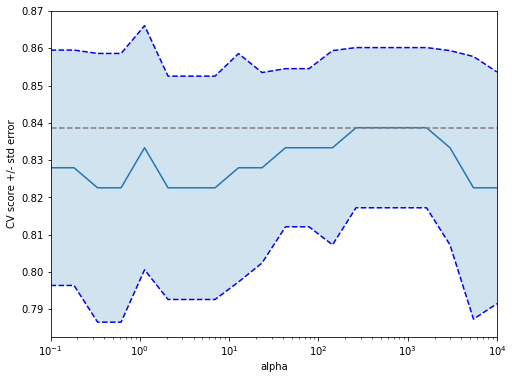

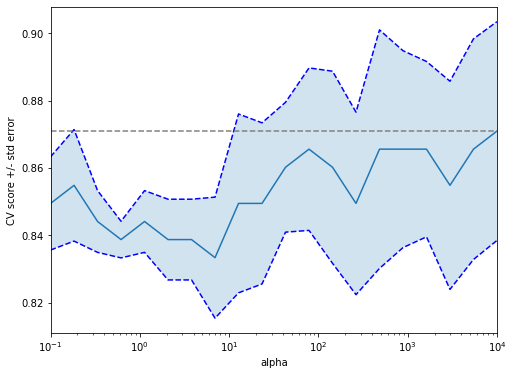

In [25]:
#model_names = ['logistic', 'ridge', 'lasso', 'svm', 'rbf']
#params_grid = [{'solver' : 'lbfgs'}, {'solver' : 'svd'}, {'penalty' : 'l1', 'solver' : 'liblinear'}, {'gamma' : 'auto', 'kernel' : 'linear'}, {'gamma' : 'auto', 'kernel' : 'rbf'}]
model_names = ['logistic', 'lasso']
params_grid = [{'solver' : 'lbfgs'}, {'penalty' : 'l1', 'solver' : 'liblinear'}]
models = []

for idx, name in enumerate(model_names):
    print(name)
    model = LinearModel(name, params_grid[idx])
    best_params = model.grid_search(4, norm_X_train, y_train, 0)
    best_params = {**params_grid[idx], **best_params}
    print(best_params)
    model = LinearModel(name, best_params)
    model.run_cv(norm_X_train, y_train, 4)
    models.append(model)

# Test Set Predictions

In [26]:
all_models = models + [lgbm_model, rf_model]

gimus4
gimus3


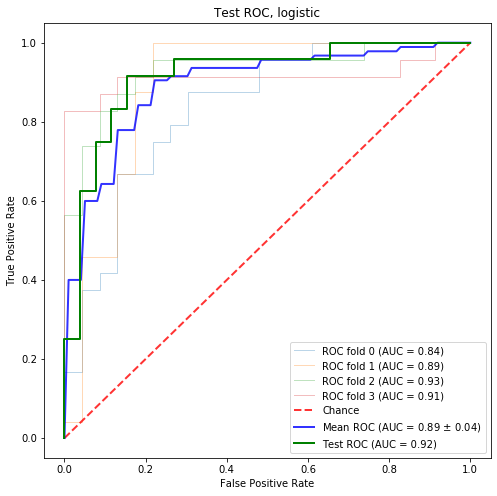

Model Name: logistic
AUC: 0.9150641025641024
AUC COV: 0.0017732273532858815
95% AUC CI: [0.8325306  0.99759761]
[0.8325306  0.99759761]

gimus4
gimus3


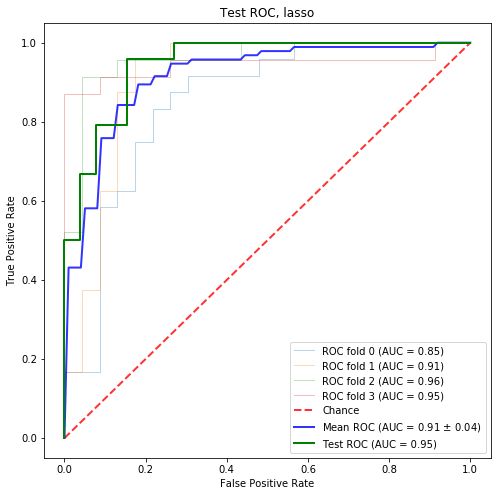

Model Name: lasso
AUC: 0.9471153846153846
AUC COV: 0.000809348469256496
95% AUC CI: [0.89135627 1.        ]
[0.89135627 1.        ]

gimus4


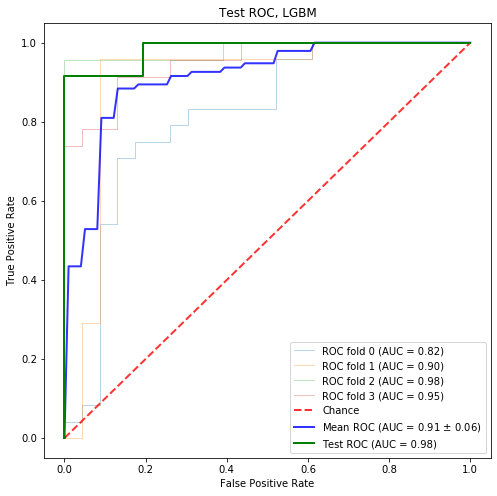

Model Name: LGBM
AUC: 0.983974358974359
AUC COV: 0.00016597347282966011
95% AUC CI: [0.95872401 1.        ]
[0.95872401 1.        ]

gimus4


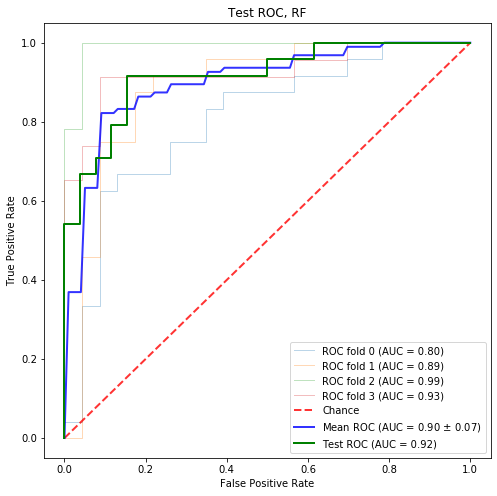

Model Name: RF
AUC: 0.9166666666666667
AUC COV: 0.0015508068204556499
95% AUC CI: [0.83948273 0.99385061]
[0.83948273 0.99385061]



In [27]:
from operator import attrgetter
from models import LinearModel as LM

test_fprs = []
test_tprs = []
test_aucs = []
i = 0
for model in all_models:
    print('gimus4')
    if i == 0 or i == 1:
        print('gimus3')
        y_pred_prob = model.avgd_folds_decision_function(norm_X_test)
    else:
        y_pred_prob = model.avgd_folds_decision_function(X_test)
    fpr, tpr, auc = model.get_prediction_stats(y_test, y_pred_prob)
    test_fprs.append(fpr)
    test_tprs.append(tpr)
    test_aucs.append(auc)
    cv_fprs, cv_tprs, cv_auc = attrgetter('fprs', 'tprs', 'auc')(model.cv_storage)
    _, _, _, fig = plotting.plot_roc_curve_folds_with_test_roc(cv_fprs, cv_tprs, cv_auc, fpr, tpr, auc, 'Test ROC, {}'.format(model.model_name))
    fig.show()
    print("Model Name: {}".format(model.model_name))
    print(delong.compute_stats(.95, y_pred_prob, y_test))
    print()
    i += 1

In [41]:
cis = {
    'logistic': [0.8325306, 0.99759761],
    'lasso': [0.89135627, 1.],
    'RF': [0.83948273, 0.99385061],
    'LGBM': [0.95872401, 1.]
}
    
name_dict = {
    "logistic": "Ridge",
    "lasso": "Lasso",
    "LGBM": "LGBM",
    "RF": "RF     "
}

# All-in-one ROC Curve

['logistic', 'lasso', 'LGBM', 'RF']


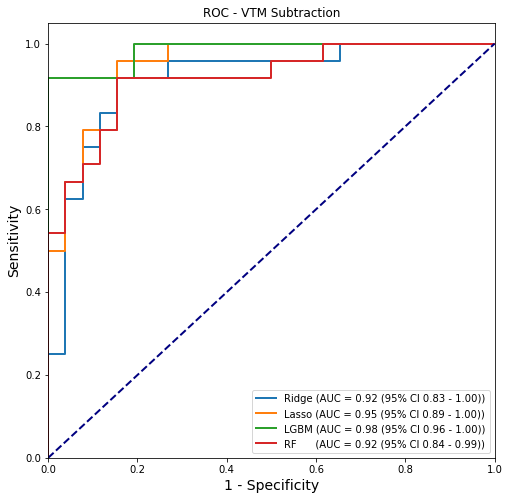

In [51]:
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels

fig = plt.figure(figsize=(8,8))
names = model_names + ['LGBM', 'RF']
print(names)
lw = 2
for l in range(len(test_fprs)):
    plt.plot(test_fprs[l], test_tprs[l],
    lw=lw, label=name_dict[names[l]] + ' (AUC = %0.2f (95%% CI %0.2f - %0.2f))' % (test_aucs[l], cis[names[l]][0], cis[names[l]][1]))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC - VTM Subtraction')
plt.legend(loc="lower right")
plt.show()
fig.savefig("vtm_subtraction.png")

# Feature Importance - SHAP 

In [ ]:
import shap

target_models = ['lasso', 'LGBM', 'RF']
for i in range(len(all_models)):
    if names[i] not in target_models:
        continue
        
    aggregated_shap_values = all_models[i].cv_shap_values(X_test, y_test)
    print(aggregated_shap_values.shape)
    print(names[i])
    if names[i] == 'lasso':
        shap.summary_plot(aggregated_shap_values, X_test, feature_names=col_names)
    else:
        shap.summary_plot(aggregated_shap_values, test.iloc[:, :-2])